<a href="https://colab.research.google.com/github/shawntharoo/GoogleColabProjects/blob/main/Copy_of_MBA509_Lesson_4_Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MBA509 Lesson #4: Natural Language Processing for Sentiment Analysis

We will cover the following Deep Learning algorithms:
* Convolutional Neural Networks
* Long-Short-Term-Memory (LSTMs), which is a type of Recurrent Neural Network (RNNs)
* BERT - which is a family of algorithms known as Transformers

**Mounting Google Drive**

* Colab needs to be connected (mount) to Google Drive. This connection allows Colab to save data (e.g. CSV files) to Google Drive.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Install Libraries**

In [ ]:
!pip install ludwig

In [ ]:
!pip install ludwig[text]

In [ ]:
!pip install ludwig[visualize]

In [ ]:
!pip install petastorm

**Import Libraries**

In [ ]:
import ludwig
from ludwig.api import LudwigModel

In [ ]:
from ludwig.visualize import learning_curves, compare_performance, compare_classifiers_predictions

In [ ]:
from ludwig import visualize

In [ ]:
from ludwig.utils.nlp_utils import load_nlp_pipeline, process_text

In [ ]:
from ludwig.utils.data_utils import load_json

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
from matplotlib import pyplot as plt
import yaml
import pandas as pd
import numpy as np

In [ ]:
import logging

# Load Dataset & Preprocess Data

* Twitter Tweets

**Twitter Tweets**

In [ ]:
# create a variable to store tweets data
tweets  = pd.read_csv('https://s3.ap-northeast-1.wasabisys.com/pubdatasets/tweets/sentiment140_160k_tweets_train.csv')

In [ ]:
tweets

,target,ids,user,text
0,p,1978186076,ceruleanbreeze,"@nocturnalie Anyway, and now Abby and I share ..."
1,p,1994697891,enthusiasticjen,@JoeGigantino Few times I'm trying to leave co...
2,p,2191885992,LifeRemixed,@AngieGriffin Good Morning Angie I'll be in t...
3,p,1753662211,lovemandy,"had a good day driving up mountains, visiting ..."
4,p,2177442789,_LOVELYmanu,downloading some songs i love lady GaGa.
...,...,...,...,...
159980,n,1827557704,starrjonze,@sherylmae Same here! Listening to &quot;BBC S...
159981,n,2190737777,feetonheat,Watching Arashi &gt; Research Methods B report...
159982,n,2178341929,lewisreilly,is not looking forward to results today .. bri...
159983,n,1836168272,mizprettyash,@chasdizz it was painful....it still hurts too


In [ ]:
# find/match for negative sentiments
tweets[tweets['target'].str.match('n')]

,target,ids,user,text
80000,n,2016716370,Cinesv,"has just been in a funeral, oh gosh how I miss..."
80001,n,2067684380,yanarropak,Man.. I wish a lot of things
80002,n,2326540525,Heyhomee,"@GeeNote no, I feel like trash, sitting on the..."
80003,n,1827835793,ilikedinosrawr,Eff. Working 1 to 8
80004,n,2263145821,sfgiantsgirl,"@Tina_Murphy @AK618 sadly, true but at least ..."
...,...,...,...,...
159980,n,1827557704,starrjonze,@sherylmae Same here! Listening to &quot;BBC S...
159981,n,2190737777,feetonheat,Watching Arashi &gt; Research Methods B report...
159982,n,2178341929,lewisreilly,is not looking forward to results today .. bri...
159983,n,1836168272,mizprettyash,@chasdizz it was painful....it still hurts too


In [ ]:
tweets.shape

(159985, 4)

In [ ]:
tweets.target.unique

<bound method Series.unique of 0         p
1         p
2         p
3         p
4         p
         ..
159980    n
159981    n
159982    n
159983    n
159984    n
Name: target, Length: 159985, dtype: object>

In [ ]:
tweets.target.value_counts()

p    80000
n    79985
Name: target, dtype: int64

In [ ]:
grouped_tweets = tweets.groupby('target')
grouped_tweets.apply(lambda x: x.sample(grouped_tweets.size().min()))

target  ...                                               text
target                ...                                                   
n      126555      n  ...      Today is like a mirror image of the feelings 
       140413      n  ...  is back home as she doubts that Captain Kirk w...
       111391      n  ...  Ugh wth my stupid phone only sends me the twee...
       128892      n  ...  @dollymix184 Wow, I've officially lost all fai...
       122889      n  ...                   Studying for the Chemistry exam 
...              ...  ...                                                ...
p      71808       p  ...  @_wendy_r_ we bought tix to see it tomorrow, W...
       18932       p  ...  alright its 4am. off to bed. talk to u all later 
       13005       p  ...  Holla at u later!!  going to Gonzalez in the G...
       25830       p  ...  mm great, we have a cheer performance tomorrow...
       1234        p  ...  @alexjmann yea i was like &quot;wtf is alex's ...

[159970 rows x 4 columns]

**Preprocess Data**

We will need three small samples of data for convenience:
* data for training algorithms (teaching it)
* data for the algorithm to validate what it has learned
* data for testing to see how well it has learned
* Finally, we will create a "fake" tweet to see if the algorithms can accurately determine the sentiment in the sentences

* frac - specifies the percentage of data to take
* random state - ensures that the sampling is repeatable

In [ ]:
# first lets convert the target column to binary
tweets['target'] = tweets['target'].apply(lambda x: 1 if x =='p' else 0)

In [ ]:
grouped_tweets = tweets.groupby('target')
grouped_tweets.apply(lambda x: x.sample(g.size().min()))

target  ...                                               text
target                 ...                                                   
0      107193       0  ...                         @JanieceLincoln Me too... 
       94517        0  ...  is so, so sad that she can't wish her mother a...
       156596       0  ...  Whos gonna be my 50th follower???? ....I know ...
       149367       0  ...                           @JulieeM dude i'm sick! 
       132151       0  ...  Reading Graceling by Kristin Cashore. I havent...
...               ...  ...                                                ...
1      893          1  ...    @selenagomez thats nice .... have fun together 
       51498        1  ...  Watching Step up 2 before bedtime...getting in...
       21787        1  ...  Jenson Button - 6 wins from 7 races!!!!!!!   H...
       14378        1  ...  any legal studies/law students out there twitt...
       38080        1  ...  I've always supported Twitter w/ 2 exceptions ...

[159970 rows x 4 columns]

In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159985 entries, 0 to 159984
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  159985 non-null  int64 
 1   ids     159985 non-null  int64 
 2   user    159985 non-null  object
 3   text    159985 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB


In [ ]:
# examine the dataframe again
tweets

,target,ids,user,text
0,1,1978186076,ceruleanbreeze,"@nocturnalie Anyway, and now Abby and I share ..."
1,1,1994697891,enthusiasticjen,@JoeGigantino Few times I'm trying to leave co...
2,1,2191885992,LifeRemixed,@AngieGriffin Good Morning Angie I'll be in t...
3,1,1753662211,lovemandy,"had a good day driving up mountains, visiting ..."
4,1,2177442789,_LOVELYmanu,downloading some songs i love lady GaGa.
...,...,...,...,...
159980,0,1827557704,starrjonze,@sherylmae Same here! Listening to &quot;BBC S...
159981,0,2190737777,feetonheat,Watching Arashi &gt; Research Methods B report...
159982,0,2178341929,lewisreilly,is not looking forward to results today .. bri...
159983,0,1836168272,mizprettyash,@chasdizz it was painful....it still hurts too


**Dataset to train the algorithm**

In [ ]:
# take a small sample of tweets to train machine learning
tweets_train = tweets.sample(frac=0.01, replace=False, random_state=3)

In [ ]:
tweets_train

,target,ids,user,text
31939,1,1981722171,giogoirocks,sun shining! FACE MASKS
68848,1,1989165331,staaceeyy,@judez_xo omg i hate you ily.
24932,1,2174706602,paigezewizard,I will be fiveteen in a matter of one hour
1028,1,1978953198,funkagenda,@drunkos Nah there is a mistake on it I will ...
146962,0,1553576804,chathura88,again back to Ubuntu 8.10 form Fedora
...,...,...,...,...
60778,1,1963465031,anaquinhos,@juvman enjoy your meal!
47474,1,1992580965,kiki2u,@Jitterjugs @ZanMac I am using NIN in the cere...
152392,0,1556699941,AttackNat,"waste of time, this function. and fight with d..."
7242,1,2046866507,clairedarbos,@thomasfiss answer me on my message of faceboo...


**Dataset for validation**

In [ ]:
tweets_validation = tweets.sample(frac=0.001, replace=False, random_state=3)

In [ ]:
tweets_validation

,target,ids,user,text
31939,1,1981722171,giogoirocks,sun shining! FACE MASKS
68848,1,1989165331,staaceeyy,@judez_xo omg i hate you ily.
24932,1,2174706602,paigezewizard,I will be fiveteen in a matter of one hour
1028,1,1978953198,funkagenda,@drunkos Nah there is a mistake on it I will ...
146962,0,1553576804,chathura88,again back to Ubuntu 8.10 form Fedora
...,...,...,...,...
143433,0,2014634007,RachaelEvans,"scary motorway incident this morning, im okay..."
86153,0,1834505590,bubswebb,is all snuggled up in ther blanket and watchin...
819,1,1976763382,yashka,"@lauralassiter Hi Laura, hope you had a beauti..."
50074,1,1573785532,clueaday,#110 also solved by @counterspark


**Dataset for testing**

In [ ]:
tweets_test = tweets.sample(frac=0.001, replace=False, random_state=3)

In [ ]:
tweets_test

,target,ids,user,text
31939,1,1981722171,giogoirocks,sun shining! FACE MASKS
68848,1,1989165331,staaceeyy,@judez_xo omg i hate you ily.
24932,1,2174706602,paigezewizard,I will be fiveteen in a matter of one hour
1028,1,1978953198,funkagenda,@drunkos Nah there is a mistake on it I will ...
146962,0,1553576804,chathura88,again back to Ubuntu 8.10 form Fedora
...,...,...,...,...
143433,0,2014634007,RachaelEvans,"scary motorway incident this morning, im okay..."
86153,0,1834505590,bubswebb,is all snuggled up in ther blanket and watchin...
819,1,1976763382,yashka,"@lauralassiter Hi Laura, hope you had a beauti..."
50074,1,1573785532,clueaday,#110 also solved by @counterspark


# Exploratory Data Analysis

* Create a word cloud to see prominent words in the tweets

In [ ]:
# use the entire tweets
processed_train_data = process_text(' '.join(tweets['text']),
                                    load_nlp_pipeline('en'),
                                    filter_punctuation=True,
                                    filter_stopwords=True)

Loading NLP pipeline
 spaCy {} model is missing, downloading it (this will only happen once)


/usr/local/lib/python3.7/dist-packages/spacy/util.py:740: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.1.2,<3.2.0
  warnings.warn(warn_msg)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# create the word cloud variable to store the words
wordcloud = WordCloud(background_color='black', collocations=False,
                      stopwords=STOPWORDS).generate(' '.join(processed_train_data))

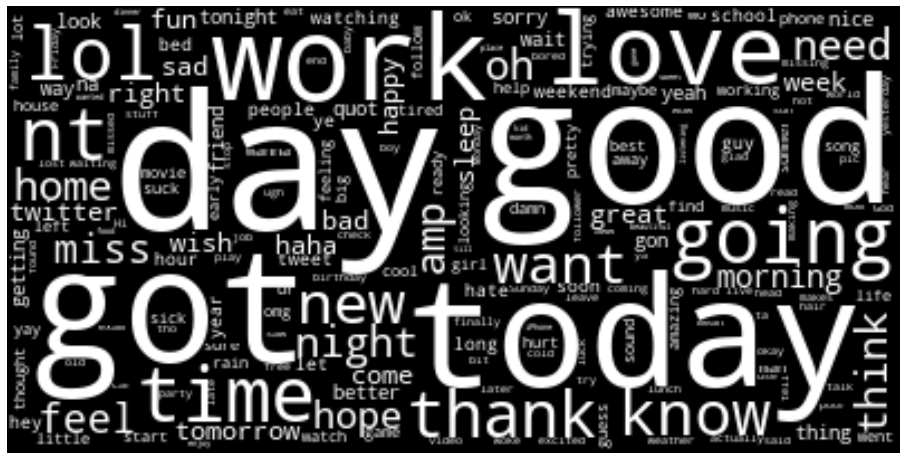

In [ ]:
# use matplotlib to visualise the data stored in wordcloud variable
plt.figure(figsize=(16,16))
plt.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs:'white'), interpolation='bilinear')
plt.axis('off')
plt.show()

# Machine Learning (Deep Learning) with Ludwig AI

* Ludwig is built on top of Tensorflow - an opensource AI platform from Google: https://www.tensorflow.org/
* Ludwig simplifies Tensorflow by using the  "declarative apprroach", which simply means that AI is constructed by passing parameters to Ludwig (telling Ludwig what we want)

In [ ]:
# check the training dataset again
tweets_train

,target,ids,user,text
31939,1,1981722171,giogoirocks,sun shining! FACE MASKS
68848,1,1989165331,staaceeyy,@judez_xo omg i hate you ily.
24932,1,2174706602,paigezewizard,I will be fiveteen in a matter of one hour
1028,1,1978953198,funkagenda,@drunkos Nah there is a mistake on it I will ...
146962,0,1553576804,chathura88,again back to Ubuntu 8.10 form Fedora
...,...,...,...,...
60778,1,1963465031,anaquinhos,@juvman enjoy your meal!
47474,1,1992580965,kiki2u,@Jitterjugs @ZanMac I am using NIN in the cere...
152392,0,1556699941,AttackNat,"waste of time, this function. and fight with d..."
7242,1,2046866507,clairedarbos,@thomasfiss answer me on my message of faceboo...


# Convolutional Neural Networks (CNNs)

### The rules structure required by Ludgwig AI

In [ ]:
# ludwig requires configuration in the following formats
config={
    'input_features':[],
    'output_features':[],
    'training':[]
}

**The actual configuration to pass to Ludwig**

In [ ]:
# ludwig requires a configuration setting in order to create the AI model
rules = {
    'input_features': [{ 
        'name': 'text',
        'type': 'text', 
        'level': 'word', 
        'encoder': 'parallel_cnn'
    }],
    'output_features': [{
        'name': 'target', 
        'type': 'category'}],
    'training': {
        'decay': True,
        'learning_rate': 0.001,
        'epochs': 5,
        'validation_field': 'target',
        'validation_metric': 'accuracy'
    }
}

In [ ]:
# Initialize a Ludwig model
print("Starting Ludwig...")
rules_parallel_cnn_model = LudwigModel(rules, logging_level=logging.DEBUG)

# The configuration (rules) we will provide Ludwig AI

In [ ]:
# ludwig requires a configuration setting in order to create the AI model
config = {
    'input_features': [{ 
        'name': 'text',
        'type': 'text', 
        'level': 'word', 
        'encoder': 'parallel_cnn'
    }],
    'output_features': [{
        'name': 'target', 
        'type': 'category'}],
    'training': {
        'decay': True,
        'learning_rate': 0.001,
        'epochs': 5,
        'validation_field': 'target',
        'validation_metric': 'accuracy'
    }
}

In [ ]:
# Initialize a Ludwig model
print("Starting Ludwig...")
para_cnn_model = LudwigModel(config, logging_level=logging.DEBUG)

Starting Ludwig...


In [ ]:
print("Training Model...")
train_stats_para_cnn_model, _, _ = para_cnn_model.train(
    training_set=tweets_train,
    validation_set=tweets_validation,
    test_set=tweets_test,
    model_name='para_cnn_model',
    skip_save_processed_input=True
)

Training Model...
Experiment name: api_experiment
Model name: para_cnn_model
Output directory: results/api_experiment_para_cnn_model


ludwig_version: '0.4'
command: ('/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-99aba6a4-3059-45d4-86af-6997f6c69dd2.json')
random_seed: 42
data_format: "<class 'pandas.core.frame.DataFrame'>"
config: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'column': 'text',
                              'encoder': 'parallel_cnn',
                              'level': 'word',
                              'name': 'text',
                              'proc_column': 'text_mZFLky',
                              'tied': None,
                              'type': 'text'}],
    'output_features': [   {   'column': 'target',
                               'dependencies': [],
                               'loss': {   'class_similarities_temperature': 0,
                                 

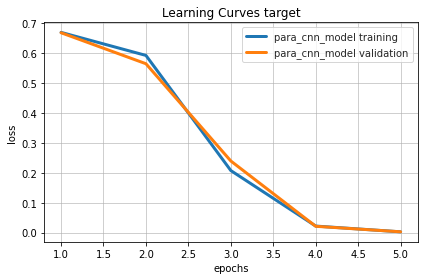

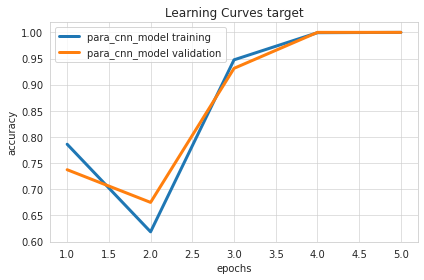

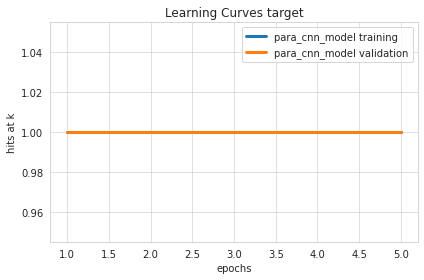

In [ ]:
# visualise training results
learning_curves(train_stats_para_cnn_model, output_feature_name='target', model_names='para_cnn_model')

# Long-Short-Term-Memory (LSTMs)

In [ ]:
config_lstm = {
    'input_features': [{
        'name': 'text',
        'type': 'text',
        'level': 'word',
        'encoder': 'rnn',
        'cell_type': 'lstm',
        'bidirectional': True
    }],
    'output_features': [{
        'name': 'target', 
        'type': 'category'
        }],
    'training': {
        'decay': True,
        'learning_rate': 0.001,
        'epochs': 5,
        'early_stop': 5,
        'validation_field': 'target',
        'validation_metric': 'accuracy'
    }
}


In [ ]:
# Initialize a Ludwig model
print("Starting Ludwig...")
bi_lstm_model = LudwigModel(config_lstm, logging_level=logging.DEBUG)

Starting Ludwig...


In [ ]:
print("Training Model...")
train_stats_bi_lstm_model, _, _ = bi_lstm_model.train(
    training_set=tweets_train,
    validation_set=tweets_validation,
    test_set=tweets_test,
    model_name='bi_lstm_model',
    skip_save_processed_input=True
)

Training Model...
Experiment name: api_experiment
Model name: bi_lstm_model
Output directory: results/api_experiment_bi_lstm_model


ludwig_version: '0.4'
command: ('/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-99aba6a4-3059-45d4-86af-6997f6c69dd2.json')
random_seed: 42
data_format: "<class 'pandas.core.frame.DataFrame'>"
config: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'bidirectional': True,
                              'cell_type': 'lstm',
                              'column': 'text',
                              'encoder': 'rnn',
                              'level': 'word',
                              'name': 'text',
                              'proc_column': 'text_mZFLky',
                              'tied': None,
                              'type': 'text'}],
    'output_features': [   {   'column': 'target',
                               'dependencies': [],
                    

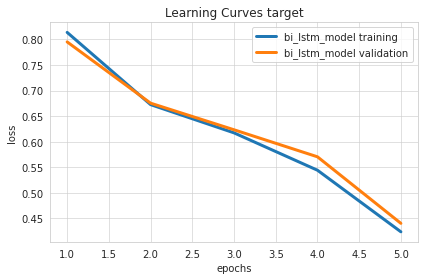

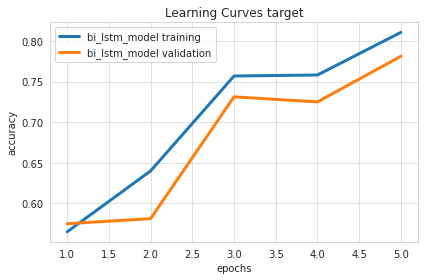

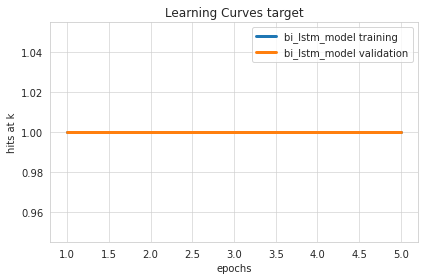

In [ ]:
# visualise training results
learning_curves(train_stats_bi_lstm_model, output_feature_name='target', model_names='bi_lstm_model')

# Deep Learning Transformers (BERT)

* An advanced language model: https://huggingface.co/transformers/model_doc/bert.html


In [ ]:
config_bert = {
    'input_features': [{
        'name': 'text',
        'type': 'text',
        'level': 'word',
        'encoder': 'bert'
    }],
    'output_features': [{
        'name': 'target', 
        'type': 'category'
        }],
    'training': {
        'decay': True,
        'batch_size': 16,
        'learning_rate': 0.002,
        'trainable': True,
        'epochs': 5
    }
}

In [ ]:
# Initialize a Ludwig model
print("Starting Ludwig...")
bert_model = LudwigModel(config_bert, logging_level=logging.DEBUG)

Starting Ludwig...


In [ ]:
print("Training Model...")
train_stats_bert_model, _, _ = bert_model.train(
    training_set=tweets_train,
    validation_set=tweets_validation,
    test_set=tweets_test,
    model_name='bert_model',
    skip_save_processed_input=True
)

In [ ]:
# visualise training results
learning_curves(train_stats_bert_model, output_feature_name='target', model_names='bert_model')

# Model Evaluation & Comparison

In [ ]:
para_cnn_model = LudwigModel.load('/content/results/api_experiment_para_cnn_model/model')
test_stats_para_cnn_model, predictions_para_cnn, _ = para_cnn_model.evaluate(
  dataset=tweets_test,
  skip_save_predictions=False,
  collect_predictions=True,
  output_directory='test_results/para_cnn_model'
  )

In [ ]:
bi_lstm_model = LudwigModel.load('/content/results/api_experiment_bi_lstm_model/model')
test_stats_bi_lstm_model, predictions_bi_lstm_model, _ = bi_lstm_model.evaluate(
  dataset=tweets_test,
  skip_save_predictions=False,
  collect_predictions=True,
  output_directory='test_results/bi_lstm_model'
  )

Evaluation test :  50%|█████     | 5/10 [00:49<00:49,  9.99s/it]


In [ ]:
bert_model = LudwigModel.load('/content/results/api_experiment_bert_model/model')
test_stats_bert_model, predictions_bert_model, _ = bert_model.evaluate(
  dataset=tweets_test,
  skip_save_predictions=False,
  collect_predictions=True,
  output_directory='test_results/bi_lstm_model'
  )

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config o

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


# Performance Comparison

### If using only Paralell Convolutional Neural Network (CNN) and Bi-Directional Long-Short-Term-Memomry (Bi-LSTM)

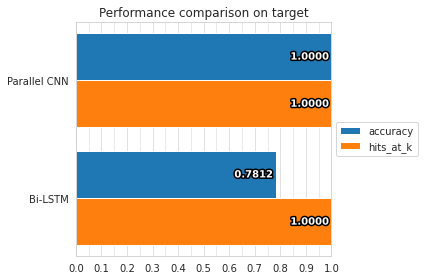

In [ ]:
compare_performance([test_stats_para_cnn_model, test_stats_bi_lstm_model],
                    output_feature_name='target', model_names=['Parallel CNN', 'Bi-LSTM'])

# Comparison if using BERT

In [ ]:
compare_performance([test_stats_para_cnn_model, test_stats_bi_lstm_model, test_stats_bert_model],
                    output_feature_name='target', model_names=['Parallel CNN', 'Bi-LSTM', 'BERT'])

# Model Predictions - Comparisons

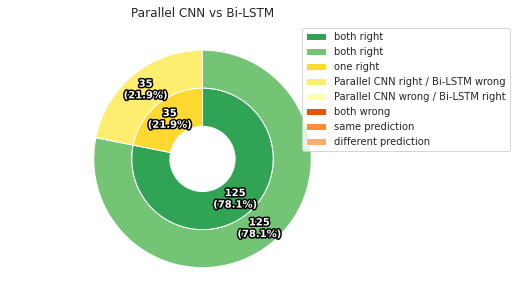

In [ ]:
metadata_para_cnn = load_json('/content/results/api_experiment_para_cnn_model/model/training_set_metadata.json')

compare_classifiers_predictions([np.array(predictions_para_cnn['target_predictions'], dtype=int),
                                np.array(predictions_bi_lstm_model['target_predictions'], dtype=int)],
                                ground_truth=np.array(tweets_test['target']), labels_limit=5,
                                output_feature_name='target', metadata=metadata_para_cnn,
                                model_names=['Parallel CNN', 'Bi-LSTM'])

# If using BERT

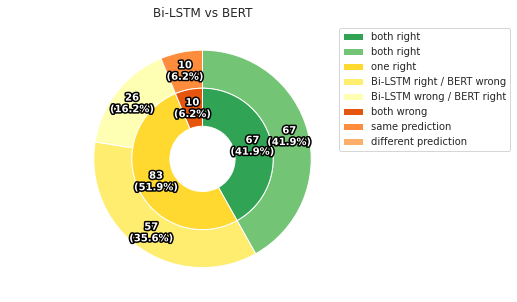

In [ ]:
metadata_bert_model = load_json('/content/results/api_experiment_bert_model/model/training_set_metadata.json')

compare_classifiers_predictions([np.array(predictions_bi_lstm_model['target_predictions'], dtype=int),
                                np.array(predictions_bert_model['target_predictions'], dtype=int)],
                                ground_truth=np.array(tweets_test['target']), labels_limit=5,
                                output_feature_name='label', metadata=metadata_bert_model,
                                model_names=['Bi-LSTM', 'BERT'])

# Test Model on New Data (Unseen Data)

**Create a list of tweets**

In [ ]:
# pretend tweets
fake_tweets = ["This is an amazing fake news!", 
         "That was an amazing game!", 
         "Wow, I can't believe it.",
         "Rubbish!",
         "It was not very good!",
         "it was terrible tweet"]

**Convert the list of tweets into a dataframe**

In [ ]:
# converting the text into dataframes
tweets_df = pd.DataFrame({'text': fake_tweets})

In [ ]:
tweets_df

,text
0,This is an amazing fake news!
1,That was an amazing game!
2,"Wow, I can't believe it."
3,Rubbish!
4,It was not very good!
5,it was terrible tweet


**Predict the sentiments of the tweets**

In [ ]:
# predicting using our best model
predictions_cnn, _ = para_cnn_model.predict(dataset=tweets_df)

In [ ]:
predictions_bi_lstm_model, _ = bi_lstm_model.predict(dataset=tweets_df)

In [ ]:
predictions_cnn

,target_predictions,target_probabilities,target_probability,target_probabilities_<UNK>,target_probabilities_1,target_probabilities_0
0,1,"[7.773248711373526e-08, 0.7806022763252258, 0....",0.780602,7.773249e-08,0.780602,0.219398
1,1,"[1.0834989438990306e-07, 0.9547227025032043, 0...",0.954723,1.083499e-07,0.954723,0.045277
2,0,"[2.485038619326474e-09, 0.07383861392736435, 0...",0.926161,2.485039e-09,0.073839,0.926161
3,1,"[6.214636960066855e-05, 0.7070261836051941, 0....",0.707026,6.214637e-05,0.707026,0.292912
4,1,"[7.972629134656017e-08, 0.8318145275115967, 0....",0.831815,7.972629e-08,0.831815,0.168185
5,0,"[3.042989192181267e-06, 0.07530622184276581, 0...",0.924691,3.042989e-06,0.075306,0.924691


In [ ]:
# pretend tweets
fake_tweets = ["This is an amazing fake news!", 
         "That was an amazing game!", 
         "Wow, I can't believe it.",
         "Rubbish!",
         "It was not very good!",
         "it was terrible tweet"]

In [ ]:
predictions_bi_lstm_model

# Suppose that you have "Customer Reviews" stored in your Google Drive as an Excel Spreadsheet. Hint: this might be the fragrance reviews.

In [ ]:
# read excel spreadsheet and create a dataframe
df = pd.read_excel('/content/drive/MyDrive/reviews.xlsx')

In [ ]:
# display dataframe
df

In [ ]:
# create a new variable called user_reviews and store the data from the reviews column
user_reviews  = df['reviews']

In [ ]:
# now create a dataframe from the user_reviews with the column heading of text (needed by AI)
user_reviews_df = pd.DataFrame({'text': user_reviews})

# Predict sentiments on user reviews

## Predict using CNN

In [ ]:
# predicting using our best model
predictions_cnn, _ = para_cnn_model.predict(dataset=user_reviews_df)

In [ ]:
predictions_cnn

In [ ]:
# save predictions to Google drive as CSV file
predictions_cnn.to_csv('/content/drive/MyDrive/predictions_cnn.csv')

## Predict using Bi-LSTM

In [ ]:
predictions_bi_lstm, _ = bi_lstm_model.predict(dataset=user_reviews_df)

In [ ]:
# save predictions as CSV file to Google drive
predictions_bi_lstm.to_csv('/content/drive/MyDrive/predictions_bilstm.csv')